In [37]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import arviz
import pandas as pd
import random
from scipy.stats import lognorm
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)

In [25]:
pyro.clear_param_store()

In [26]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=200,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-1.5, 1.5)

In [27]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

In [28]:
# Data
X = torch.tensor([-1, -0.5, 0, 0.5, 1])
y = f(X)

In [29]:
# Params given in question
lengthscaleDist = dist.LogNormal(torch.tensor(-1.), torch.tensor(1.))
varianceDist = dist.LogNormal(torch.tensor(0.), torch.tensor(2.))
noise = torch.tensor(10**(-4))

In [30]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(1)
kernel.variance = pyro.nn.PyroSample(varianceDist)
kernel.lengthscale = pyro.nn.PyroSample(lengthscaleDist)
gpr = gp.models.GPRegression(X, y, kernel, noise= noise)

In [42]:
# 10 warm up steps for tuning
pyro.clear_param_store()
nuts_kernel=NUTS(gpr.model, adapt_step_size=True)
nuts_kernel.cleanup()
mcmc=MCMC(nuts_kernel, num_samples=1000, num_chains=4, warmup_steps=100)
mcmc.run()

Warmup [1]:   0%|          | 0/1100 [00:00, ?it/s]





Warmup [1]:   0%|          | 1/1100 [00:03,  3.92s/it, step size=2.25e-01, acc. prob=1.000]


Warmup [1]:   1%|▏         | 14/1100 [00:04,  6.32it/s, step size=6.04e-01, acc. prob=0.831]




Warmup [1]:   2%|▏         | 23/1100 [00:04, 11.86it/s, step size=2.50e-01, acc. prob=0.807]



Warmup [1]:   3%|▎         | 28/1100 [00:04, 15.59it/s, step size=7.52e-02, acc. prob=0.791]




Warmup [1]:   3%|▎         | 36/1100 [00:05, 20.21it/s, step size=2.11e-01, acc. prob=0.803]





Warmup [1]:   4%|▍         | 42/1100 [00:05, 22.94it/s, step size=1.11e-01, acc. prob=0.797]

Warmup [1]:   4%|▍         | 46/1100 [00:05, 25.30it/s, step size=2.97e-01, acc. prob=0.806]

Warmup [1]:   5%|▍         | 51/1100 [00:05, 29.97it/s, step size=6.74e-01, acc. prob=0.812]


Warmup [1]:   5%|▌         | 59/1100 [00:05, 26.88it/s, step size=4.58e-01, acc. prob=0.808]




Warmup [1]:   6%|▌         | 63/1100 [00:05, 27.26it/s, step size=2.54e-01, acc. p

In [43]:
# Arviz
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary) # because we only used one chain, r_hat cannot be evauated.
plt.show()

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.313  0.180   0.030    0.632      0.006    0.004   
kernel.variance     4.577  4.706   0.613   11.276      0.166    0.117   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     945.0    1397.0    1.0  
kernel.variance       1227.0     774.0    1.0  


c:\Users\deniz\AppData\Local\Programs\Python\Python38\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


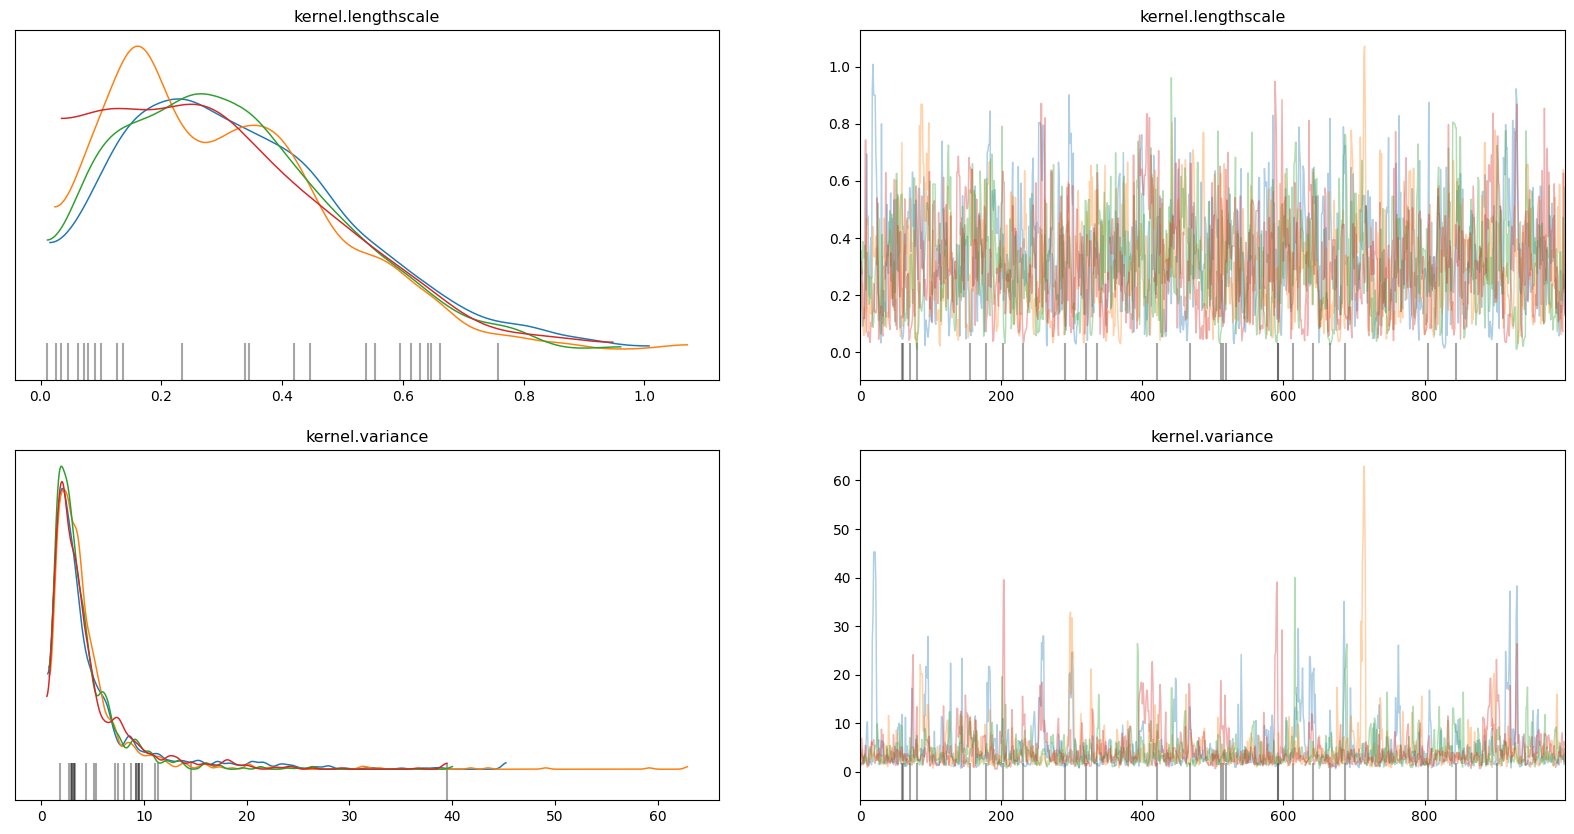

In [44]:
# Tuning trace plots
axes = arviz.plot_trace(data, kind="trace",compact=False, figsize=(20,10))
fig = axes.ravel()[0].figure
fig.savefig("trace_tune.png")

Text(0, 0.5, 'log variance')

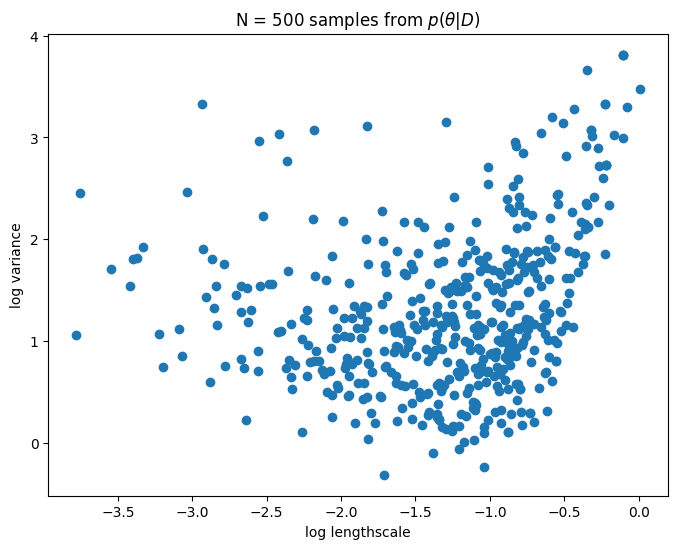

In [113]:
# Log-log plot
ls = mcmc.get_samples()['kernel.lengthscale']
v = mcmc.get_samples()['kernel.variance']

plt.subplots(figsize =(8, 6))
plt.scatter(np.log(ls[0:500]), np.log(v[0:500]))
plt.title("N = 500 samples from $p(\\theta \\vert D)$")
plt.xlabel("log lengthscale")
plt.ylabel("log variance")

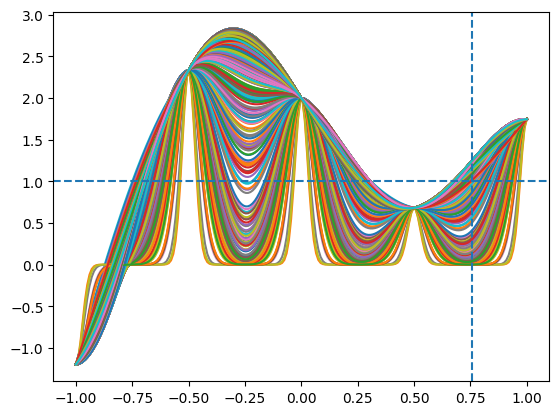

In [11]:
x_test = torch.linspace(-1.0, 1.0, 200)
y_test = f(x_test)

# Record all measurements at this index (x = 0.788)
index_X_new = 175
locs = []

for i in range(len(ls)):
    pyro.clear_param_store()
    kernel_temp = gp.kernels.RBF(input_dim=1)
    kernel_temp.variance = v[i]
    kernel_temp.lengthscale = ls[i]
    iter_gpr = gp.models.GPRegression(X, y, kernel_temp, noise = noise)

    loc, cov = iter_gpr(x_test)
    locs.append(loc.detach().numpy())

    plt.plot(x_test.detach().numpy(), locs[-1])

locs = np.array(locs)
x_new_loc = locs[:,index_X_new]
mean = np.mean(x_new_loc)
plt.axvline(x=x_test[index_X_new].detach().numpy(), linestyle = '--')
plt.axhline(y = mean, linestyle = '--')

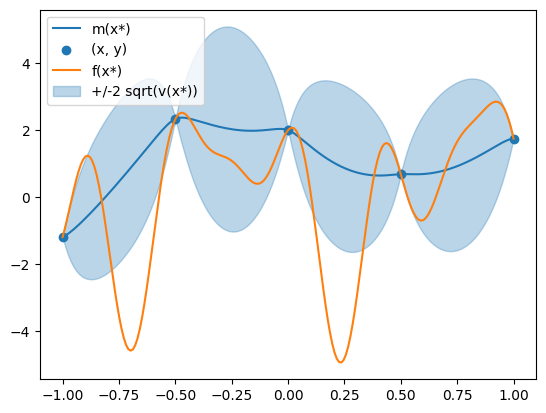

In [65]:
x_test = torch.linspace(-1.0, 1.0, 200)
y_test = f(x_test)

locs = []
covs = torch.zeros(x_test.size())
for i in range(len(ls)):
    pyro.clear_param_store()
    kernel_temp = gp.kernels.RBF(input_dim=1)
    kernel_temp.variance = v[i]
    kernel_temp.lengthscale = ls[i]
    iter_gpr = gp.models.GPRegression(X, y, kernel_temp, noise = noise)

    loc, cov = iter_gpr(x_test)
    locs.append(loc.detach().numpy())
    covs = covs + cov


locs = np.array(locs)
meanOfMeans = [np.mean(locs[:,i]) for i in range(len(locs[0]))]
variationOfMeans = np.sum((locs - meanOfMeans)**2, axis=0) / len(locs)
meanOfVars = (covs / len(ls)).detach().numpy()
fullVar = meanOfVars + variationOfMeans

plt.plot(x_test, meanOfMeans, label = "m(x*)")
plt.scatter(X, y, label ="(x, y)")
plt.plot(x_test, f(x_test), label = "f(x*)")
plt.fill_between(
    x_test,  # plot the two-sigma uncertainty about the mean
    (meanOfMeans - 2.0 * np.sqrt(fullVar)),
    (meanOfMeans + 2.0 * np.sqrt(fullVar)),
    color="C0",
    alpha=0.3,
    label = "+/-2 sqrt(v(x*))"
)
plt.legend()

# B2

In [15]:
Xstar = torch.linspace(-1.0, 1.0, 200)

In [16]:
# Draw sample from posterior
ls = mcmc.get_samples()['kernel.lengthscale']
v = mcmc.get_samples()['kernel.variance']
unif = random.randrange(len(ls))
fstar_ls = ls[unif]
fstar_v = v[unif]
print(fstar_ls, fstar_v)

tensor(0.5322) tensor(2.4693)


In [17]:
def BOA2(iter):
    Xt = X
    yt = y
    mcmct = mcmc
    for i in range(iter):
        pyro.clear_param_store()

        # Posterior samples
        ls = mcmct.get_samples()['kernel.lengthscale']
        v = mcmct.get_samples()['kernel.variance']

        # Draw a sample theta
        unif = random.randrange(len(ls))
        fstar_ls = ls[unif]
        fstar_v = v[unif]
        
        kernel_iter = gp.kernels.RBF(input_dim=1, variance=fstar_v, lengthscale=fstar_ls)
        posteriorPredictive = gp.models.GPRegression(Xt, yt, kernel_iter, noise=noise)

        # Using X2t to avoid previous mins
        f_loc, f_cov = posteriorPredictive(Xstar, full_cov = True)
        fstar = np.random.multivariate_normal(f_loc.detach().numpy(), f_cov.detach().numpy())
        val= fstar.min()
        ind = fstar.argmin()
        print(val, Xstar[ind])

        # Parameters for multivariate normal
        # Using X2 for all points
        # f_loc, f_cov = posteriorPredictive(Xstar, full_cov = True)
        # fstar = np.random.multivariate_normal(f_loc.detach().numpy(), f_cov.detach().numpy())

        
        if i % 5 == 0:
            # Plot f, f*
            plt.plot(Xstar, f(Xstar), label = "f")
            plt.plot(Xstar, fstar, label=f"f*")


            # Like earlier, integrate out theta
            locs = []
            covs = torch.zeros(Xstar.size())
            for j in range(len(ls)):
                pyro.clear_param_store()
                kernel_temp2 = gp.kernels.RBF(input_dim=1)
                kernel_temp2.variance = v[j]
                kernel_temp2.lengthscale = ls[j]
                iter2_gpr = gp.models.GPRegression(Xt, yt, kernel_temp2, noise = noise)

                loc, cov = iter2_gpr(Xstar)
                locs.append(loc.detach().numpy())
                covs = covs + cov
            
            # calculate m and v
            locs = np.array(locs)
            meanOfMeans = [np.mean(locs[:,k]) for k in range(len(locs[0]))]
            variationOfMeans = np.sum((locs - meanOfMeans)**2, axis=0) / len(locs)
            meanOfVars = (covs / len(ls)).detach().numpy()
            fullVar = meanOfVars + variationOfMeans

            # Add plot of m +-2*sqrt(v)
            plt.plot(Xstar, meanOfMeans, label = "m(x*)")
            plt.fill_between(
                x_test,  # plot the two-sigma uncertainty about the mean
                (meanOfMeans - 2.0 * np.sqrt(fullVar)),
                (meanOfMeans + 2.0 * np.sqrt(fullVar)),
                color="C0",
                alpha=0.3,
                label = "+/-2 sqrt(v(x*))"
            )
            plt.title(f"k = {i}")
            plt.legend()
            plt.show()

        
        Xt = torch.cat((Xt, torch.tensor([Xstar[ind]])))
        yt = torch.cat((yt, torch.tensor([f(Xstar[ind])])))

        kernelt = gp.kernels.RBF(1)
        kernelt.variance = pyro.nn.PyroSample(varianceDist)
        kernelt.lengthscale = pyro.nn.PyroSample(lengthscaleDist)
        gprt = gp.models.GPRegression(Xt, yt, kernel, noise = noise)

        # 10 warm up steps for tuning
        pyro.clear_param_store()
        nuts_kernelt=NUTS(gprt.model, adapt_step_size=True)
        nuts_kernelt.cleanup()
        mcmct=MCMC(nuts_kernelt, num_samples=100, num_chains=1, warmup_steps=10)
        mcmct.run()

-1.2205806781654505 tensor(-1.)


C:\Users\deniz\AppData\Local\Temp\ipykernel_19232\1771420264.py:22: RuntimeWarning: covariance is not positive-semidefinite.
  fstar = np.random.multivariate_normal(f_loc.detach().numpy(), f_cov.detach().numpy())


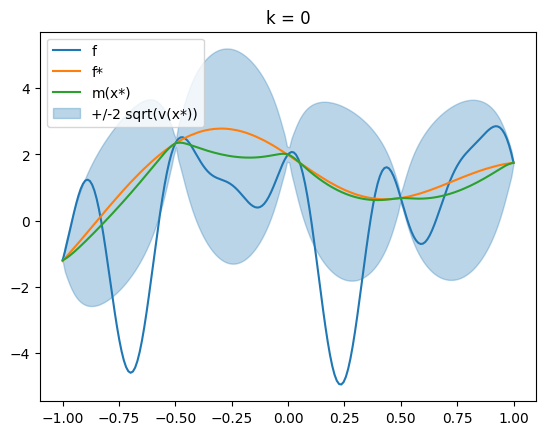

Sample: 100%|██████████| 110/110 [00:03, 34.81it/s, step size=1.91e-01, acc. prob=0.954]


-1.1951275712590037 tensor(-1.)


Sample: 100%|██████████| 110/110 [00:02, 37.94it/s, step size=2.00e-01, acc. prob=0.925]


-1.1955664178082375 tensor(-1.)


Sample: 100%|██████████| 110/110 [00:03, 29.42it/s, step size=1.39e-01, acc. prob=0.984]


-1.2199576576052467 tensor(0.2563)


Sample: 100%|██████████| 110/110 [00:04, 24.91it/s, step size=8.51e-02, acc. prob=0.973]


-4.730116254065589 tensor(0.2663)


Sample: 100%|██████████| 110/110 [00:10, 10.48it/s, step size=3.53e-02, acc. prob=0.974]


-4.7662774213148875 tensor(0.2462)


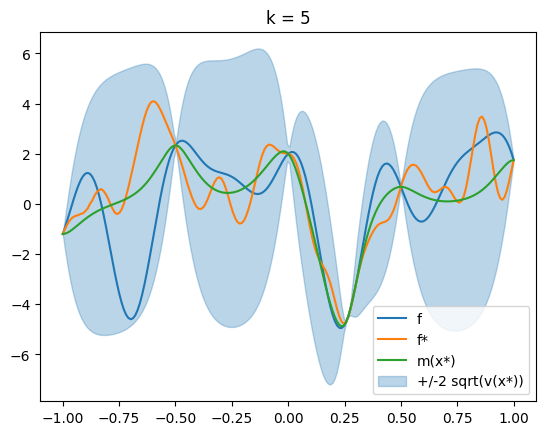

Sample: 100%|██████████| 110/110 [00:01, 55.64it/s, step size=1.98e-01, acc. prob=0.921]


-4.937803712809025 tensor(0.2362)


Sample: 100%|██████████| 110/110 [03:19,  1.82s/it, step size=1.83e-04, acc. prob=0.658]


-6.3042146649447215 tensor(0.8794)


Sample: 100%|██████████| 110/110 [00:02, 47.84it/s, step size=1.54e-01, acc. prob=0.899]


-4.949653858468265 tensor(0.2362)


Sample: 100%|██████████| 110/110 [00:02, 45.49it/s, step size=1.35e-01, acc. prob=0.947]


-4.9872862210061495 tensor(0.2261)


Sample: 100%|██████████| 110/110 [00:06, 16.73it/s, step size=3.54e-02, acc. prob=0.985]


-5.122944838391789 tensor(0.6884)


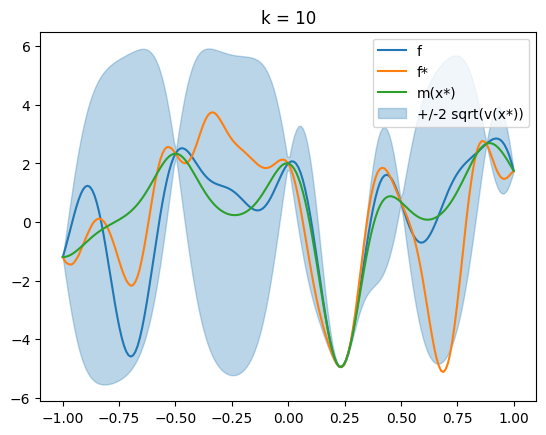

Sample: 100%|██████████| 110/110 [00:22,  4.82it/s, step size=1.06e-02, acc. prob=0.994]


In [18]:
BOA2(11)

# UCB

In [54]:
def UCB(iter, c):
    Xt = X
    yt = y
    mcmct = mcmc
    for i in range(iter):
        pyro.clear_param_store()

        # Posterior samples
        ls = mcmct.get_samples()['kernel.lengthscale']
        v = mcmct.get_samples()['kernel.variance']

        locs = []
        covs = torch.zeros(Xstar.size())
        for j in range(len(ls)):
            pyro.clear_param_store()
            kernel_temp2 = gp.kernels.RBF(input_dim=1)
            kernel_temp2.variance = v[j]
            kernel_temp2.lengthscale = ls[j]
            iter2_gpr = gp.models.GPRegression(Xt, yt, kernel_temp2, noise = noise)

            loc, cov = iter2_gpr(Xstar)
            locs.append(loc.detach().numpy())
            covs = covs + cov

        # calculate m and v
        locs = np.array(locs)
        meanOfMeans = [np.mean(locs[:,k]) for k in range(len(locs[0]))]
        variationOfMeans = np.sum((locs - meanOfMeans)**2, axis=0) / len(locs)
        meanOfVars = (covs / len(ls)).detach().numpy()
        fullVar = meanOfVars + variationOfMeans
        
        criteria = meanOfMeans - c * np.sqrt(fullVar)
        val= criteria.min()
        ind = criteria.argmin()
        print(val, ind)
        

        if i % 1 == 0:
            # Plot f, f*
            plt.subplots(figsize =(20, 10))
            plt.plot(Xstar, f(Xstar), label = "f")
            plt.title(f"k = {i}, c = {c}")

            # Add plot of m - c * v
            plt.plot(Xstar, criteria, label = "m(x*) - c * sqrt(v(x*))")
            plt.plot(Xstar, meanOfMeans, label = "m(x)")

            plt.legend()
            plt.show()
        
        Xt = torch.cat((Xt, torch.tensor([Xstar[ind]])))
        yt = torch.cat((yt, torch.tensor([f(Xstar[ind])])))

        kernelt = gp.kernels.RBF(1)
        kernelt.variance = pyro.nn.PyroSample(varianceDist)
        kernelt.lengthscale = pyro.nn.PyroSample(lengthscaleDist)
        gprt = gp.models.GPRegression(Xt, yt, kernel, noise = noise)

        # 10 warm up steps for tuning
        pyro.clear_param_store()
        nuts_kernelt=NUTS(gprt.model, adapt_step_size=True)
        nuts_kernelt.cleanup()
        mcmct=MCMC(nuts_kernelt, num_samples=100, num_chains=1, warmup_steps=10)
        mcmct.run()

-3.127685 14


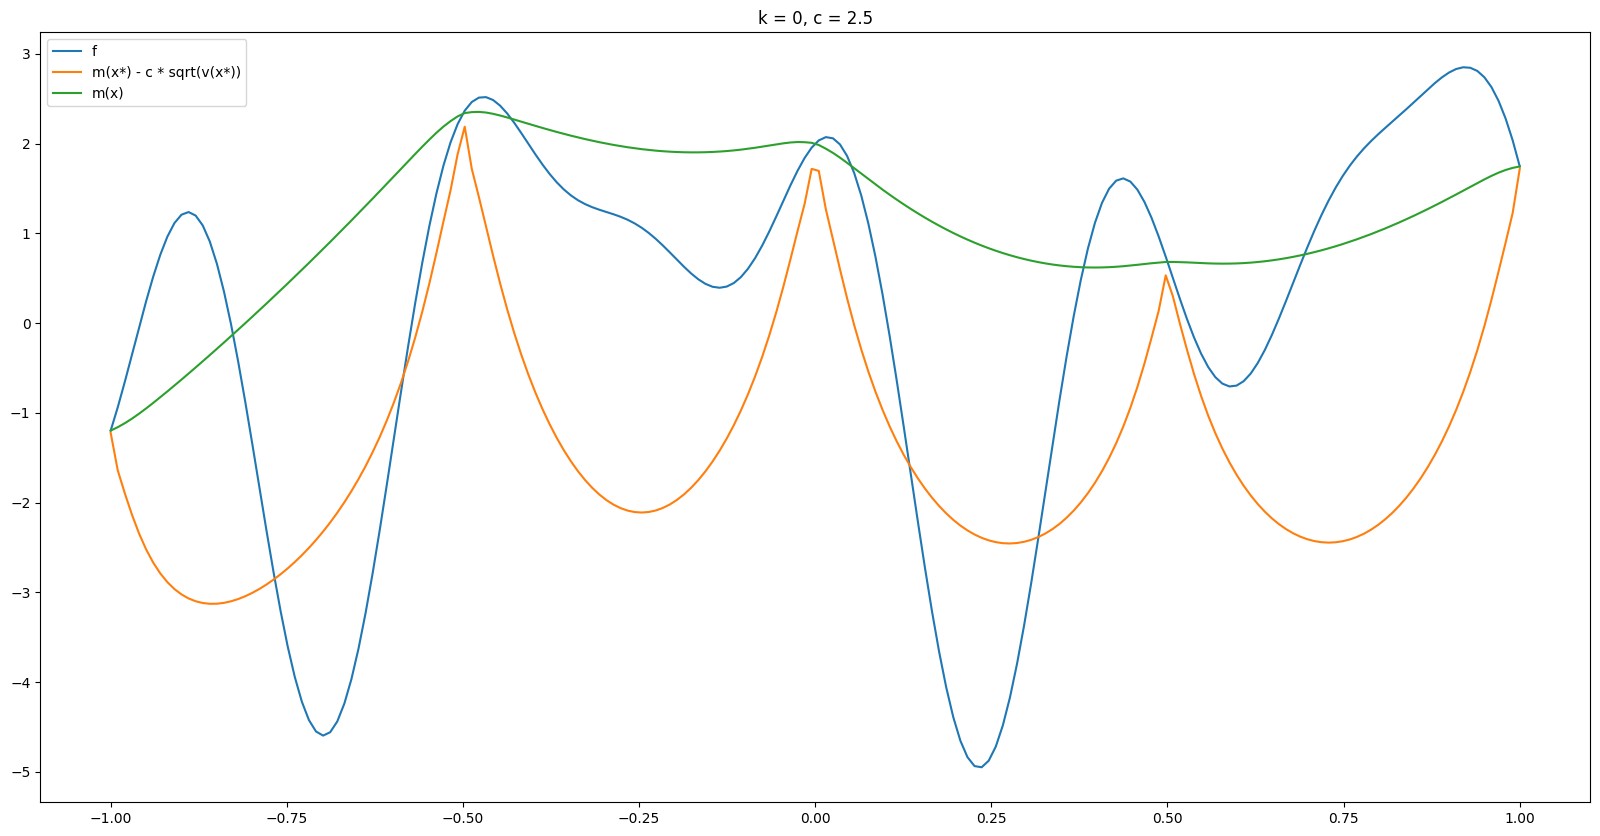

Sample: 100%|██████████| 110/110 [00:01, 61.09it/s, step size=3.20e-01, acc. prob=0.783]


-3.555398 173


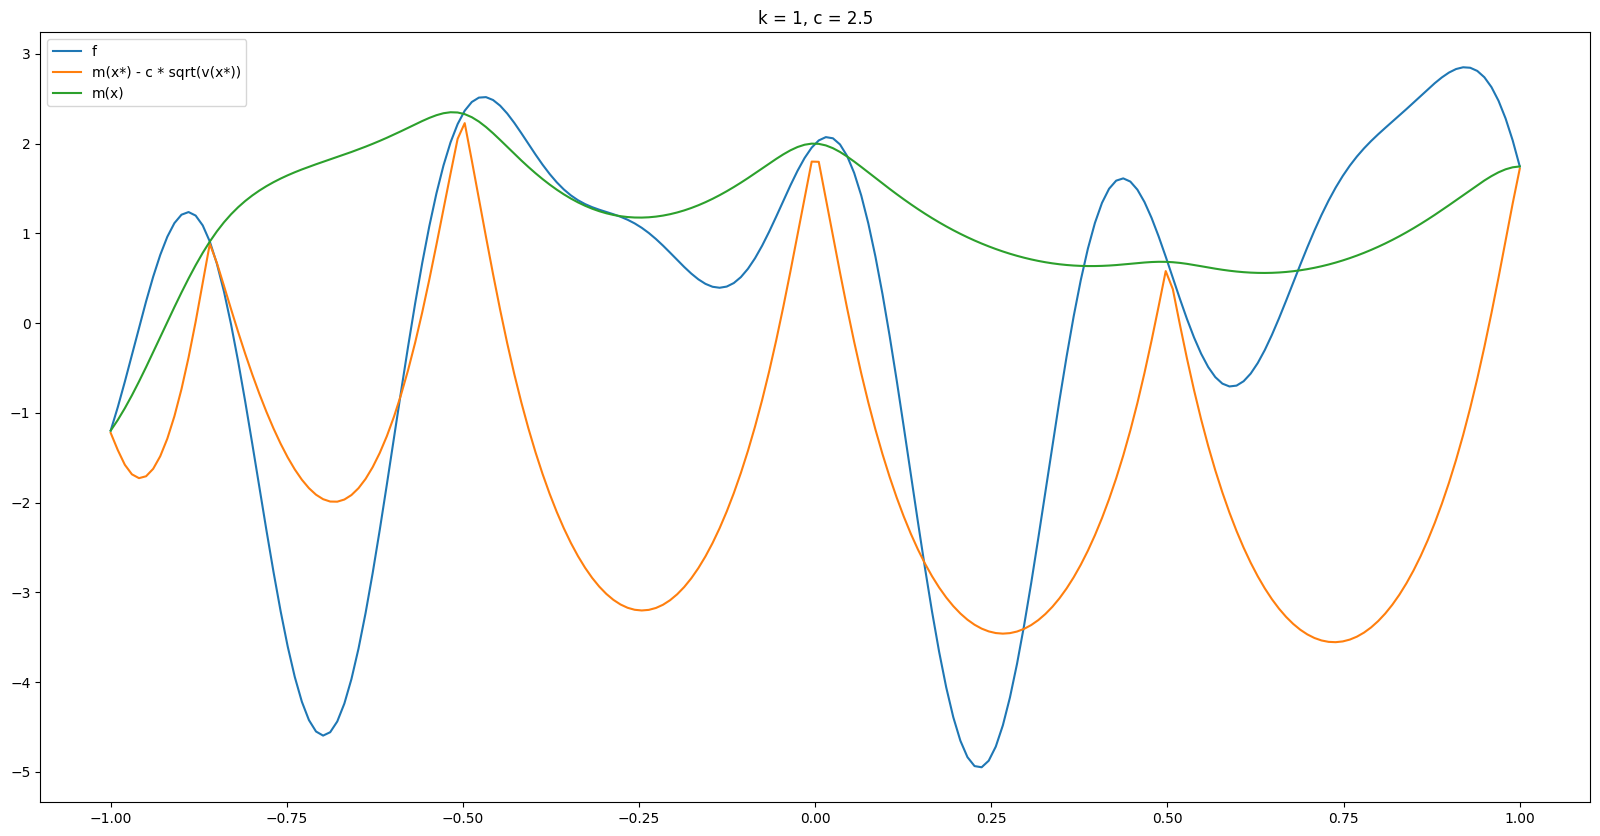

Sample: 100%|██████████| 110/110 [00:02, 38.23it/s, step size=1.63e-01, acc. prob=0.916]


-2.9496915 127


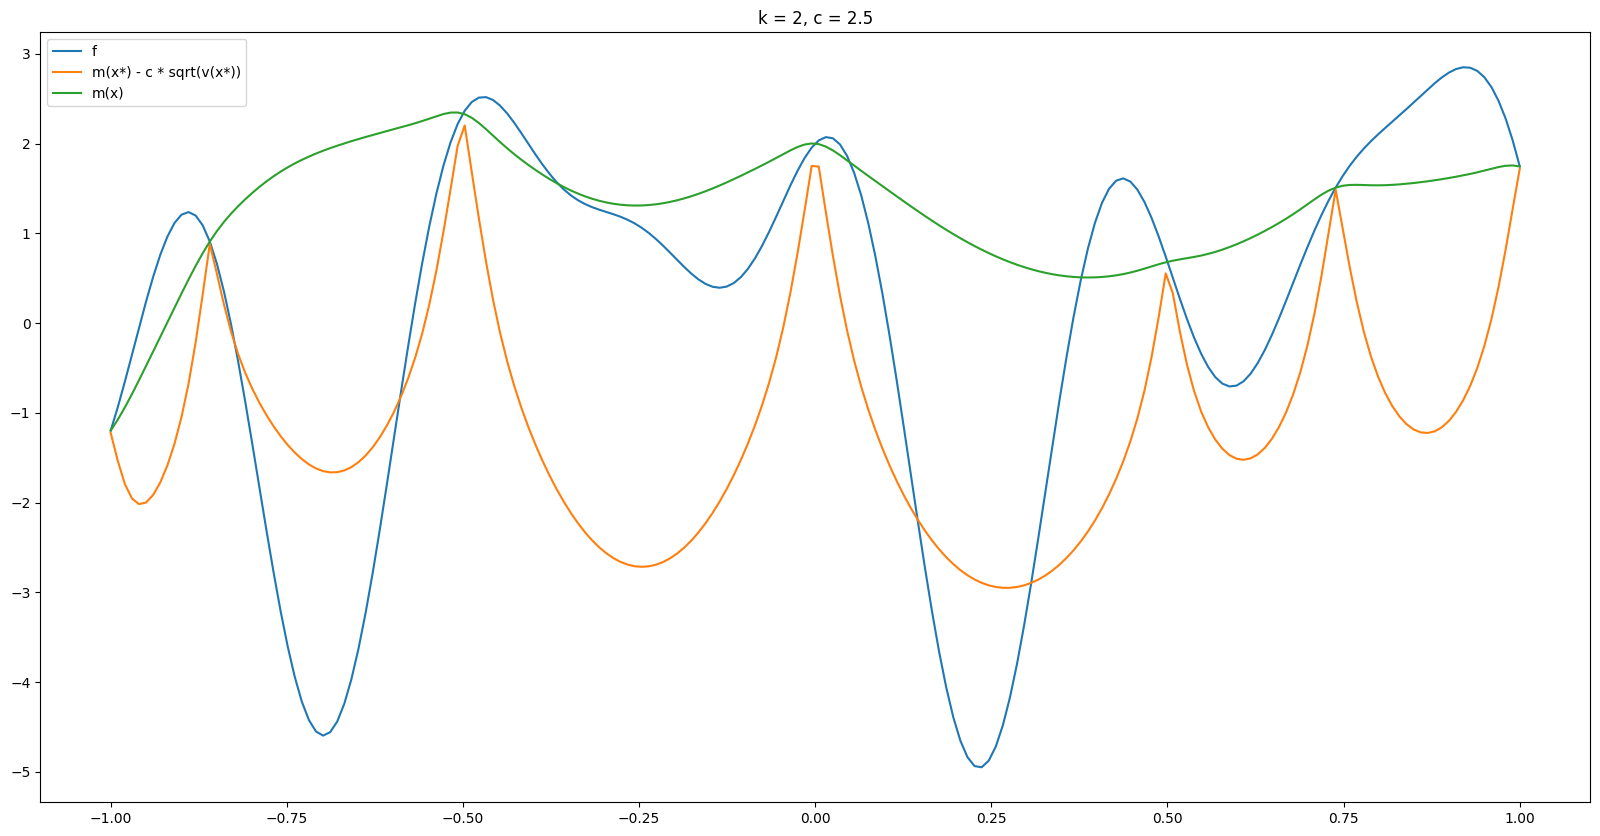

Sample: 100%|██████████| 110/110 [00:02, 52.67it/s, step size=2.41e-01, acc. prob=0.909]


-6.990794 120


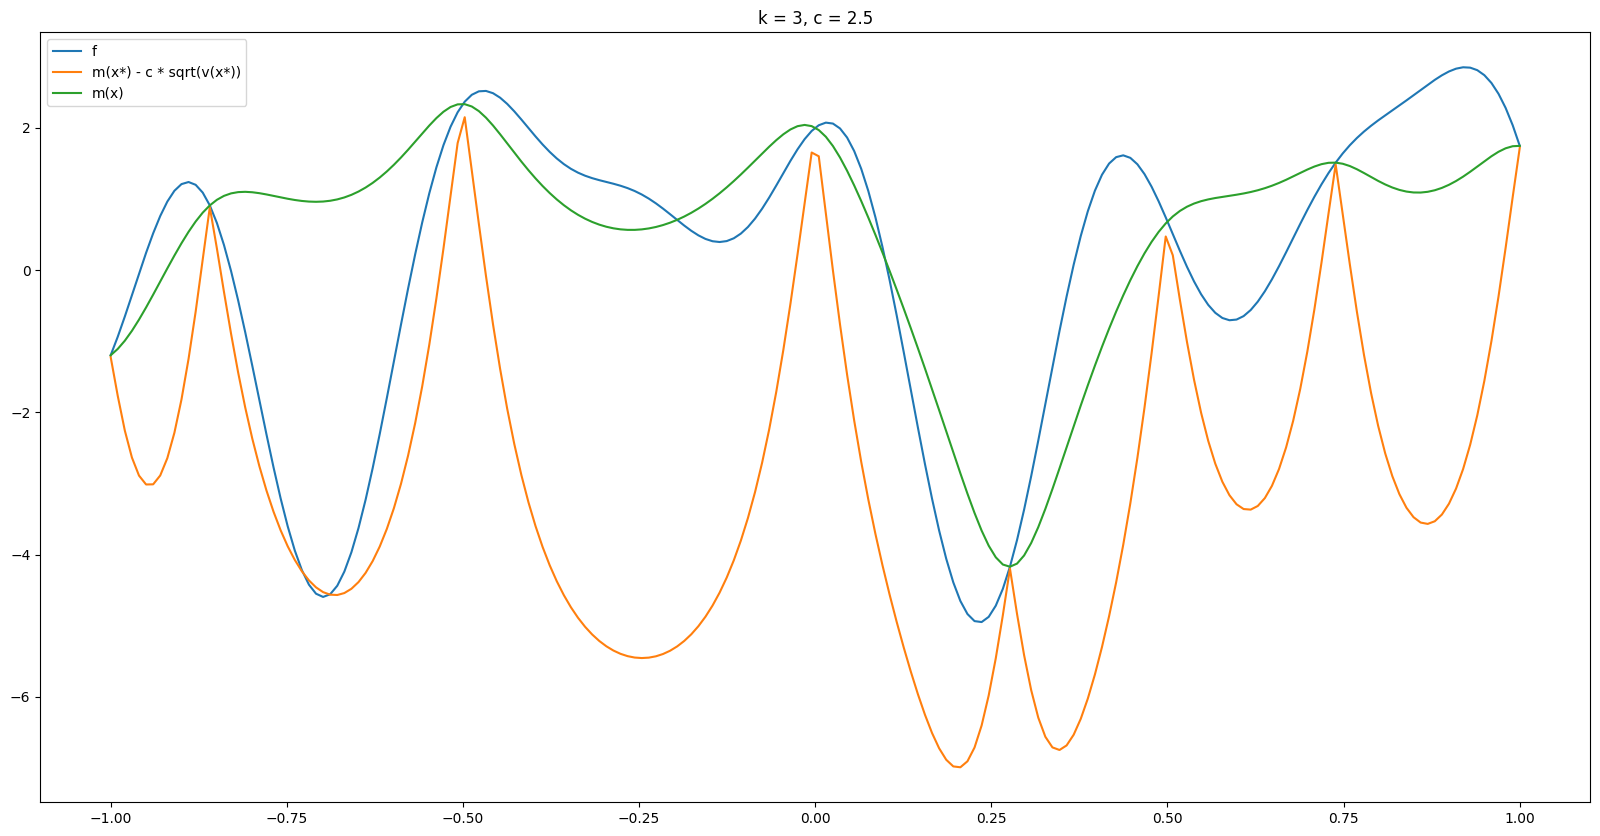

Sample: 100%|██████████| 110/110 [00:02, 38.66it/s, step size=1.45e-01, acc. prob=0.979]


-5.7225366 115


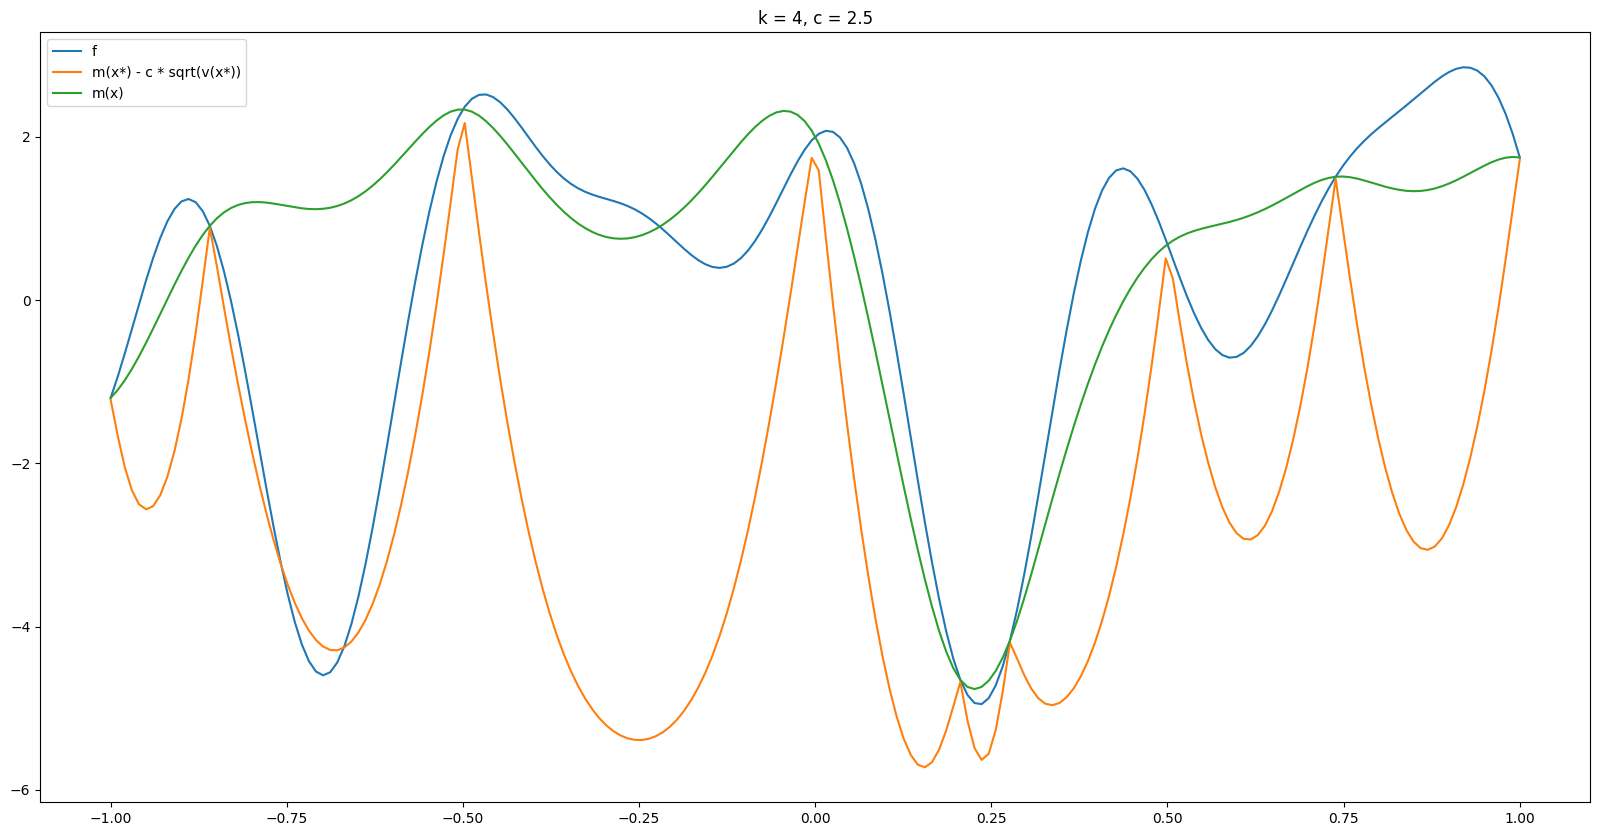

Sample: 100%|██████████| 110/110 [00:25,  4.39it/s, step size=1.00e-02, acc. prob=1.000]


-5.277787 123


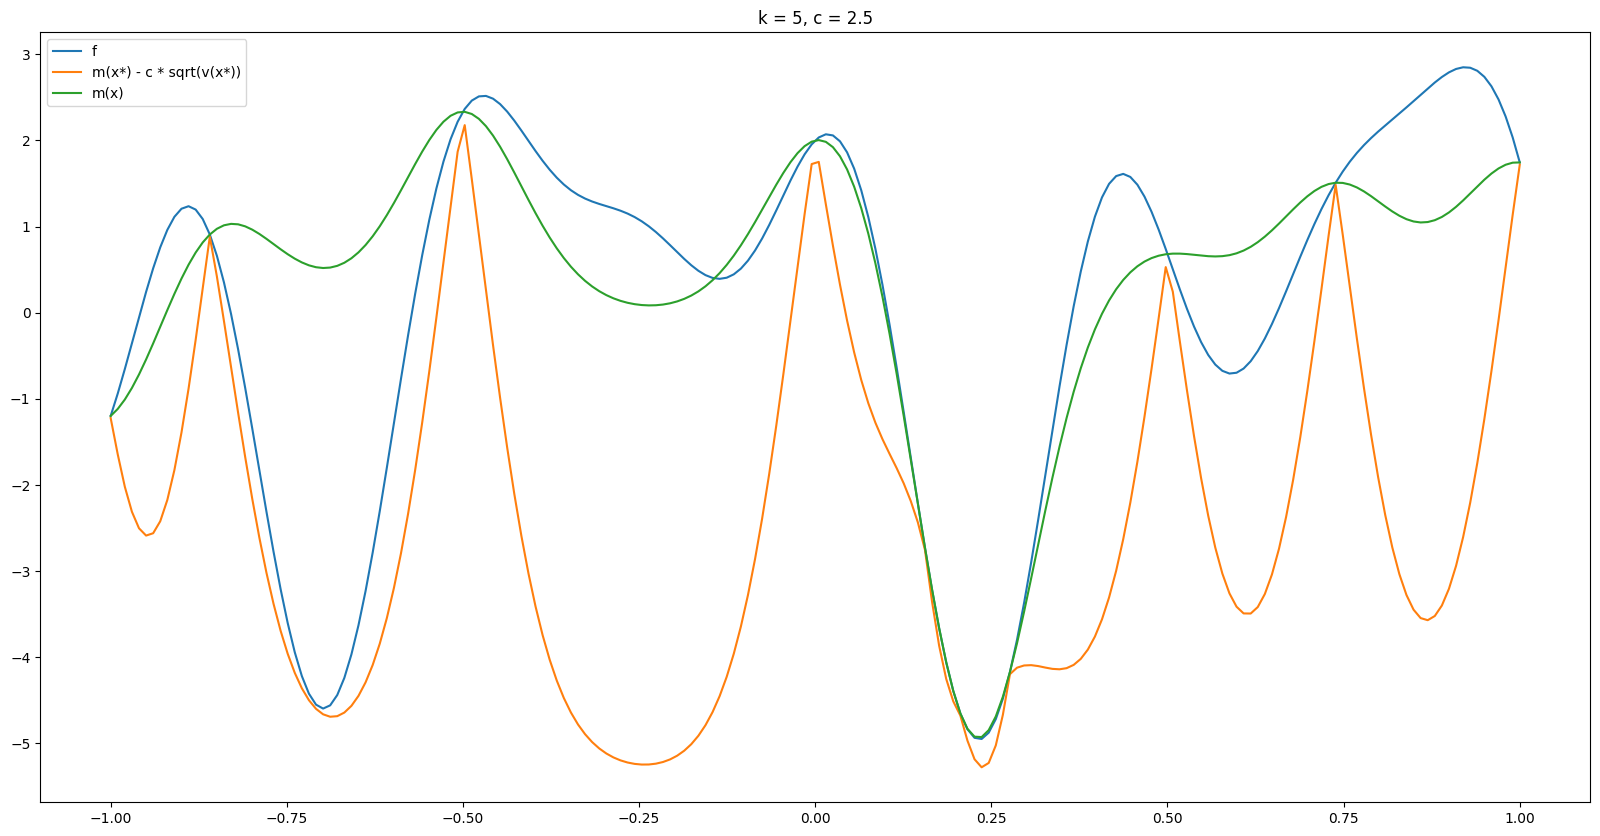

Sample: 100%|██████████| 110/110 [00:04, 26.62it/s, step size=6.59e-02, acc. prob=0.984]


-5.3584614 75


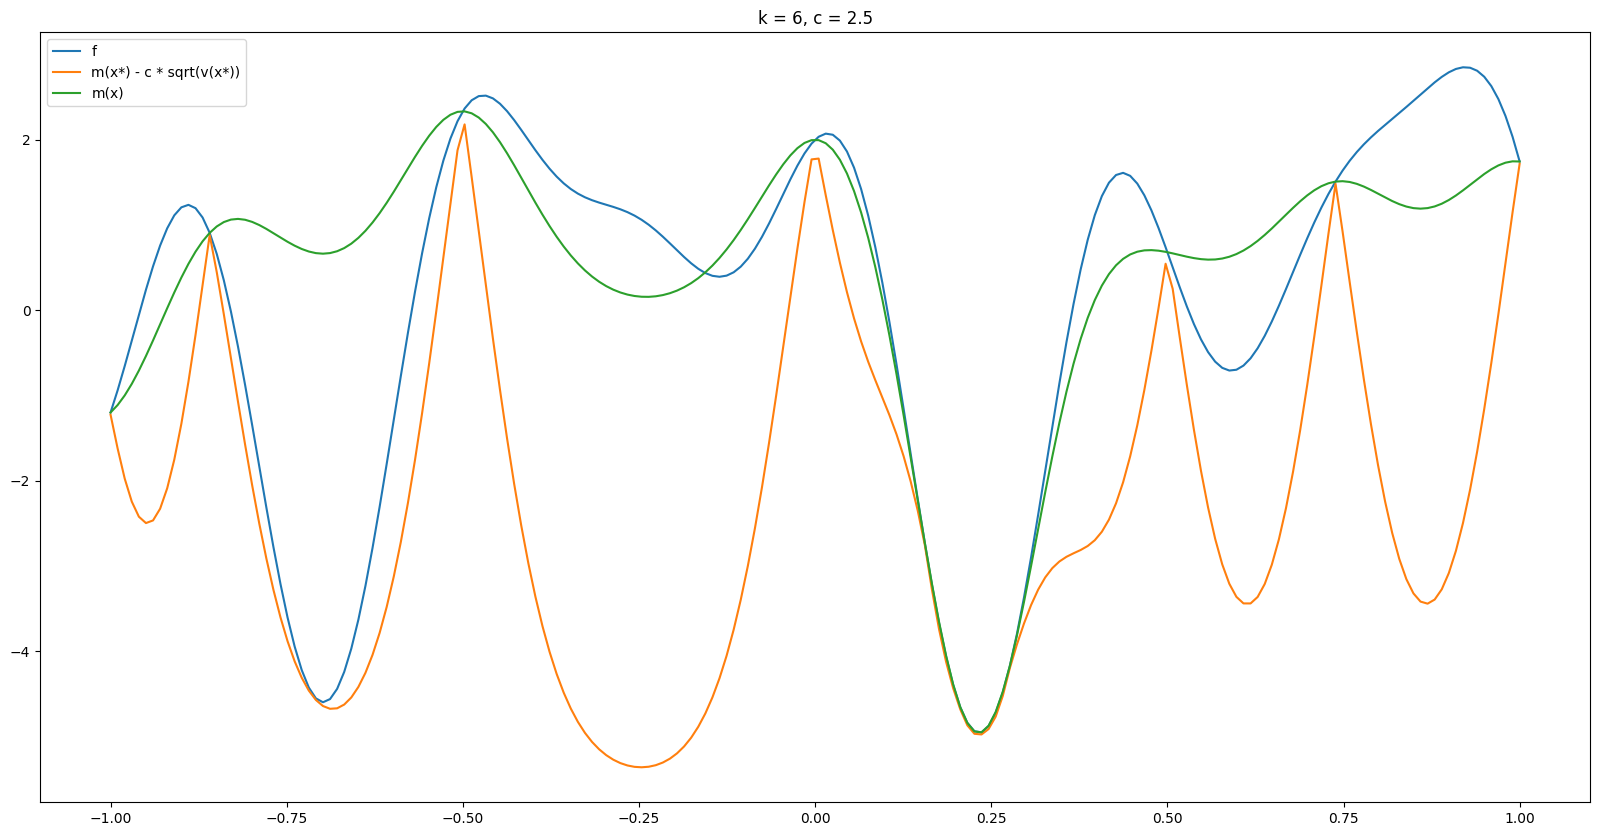

Sample: 100%|██████████| 110/110 [00:02, 42.85it/s, step size=1.31e-01, acc. prob=0.875]


-5.0582266 122


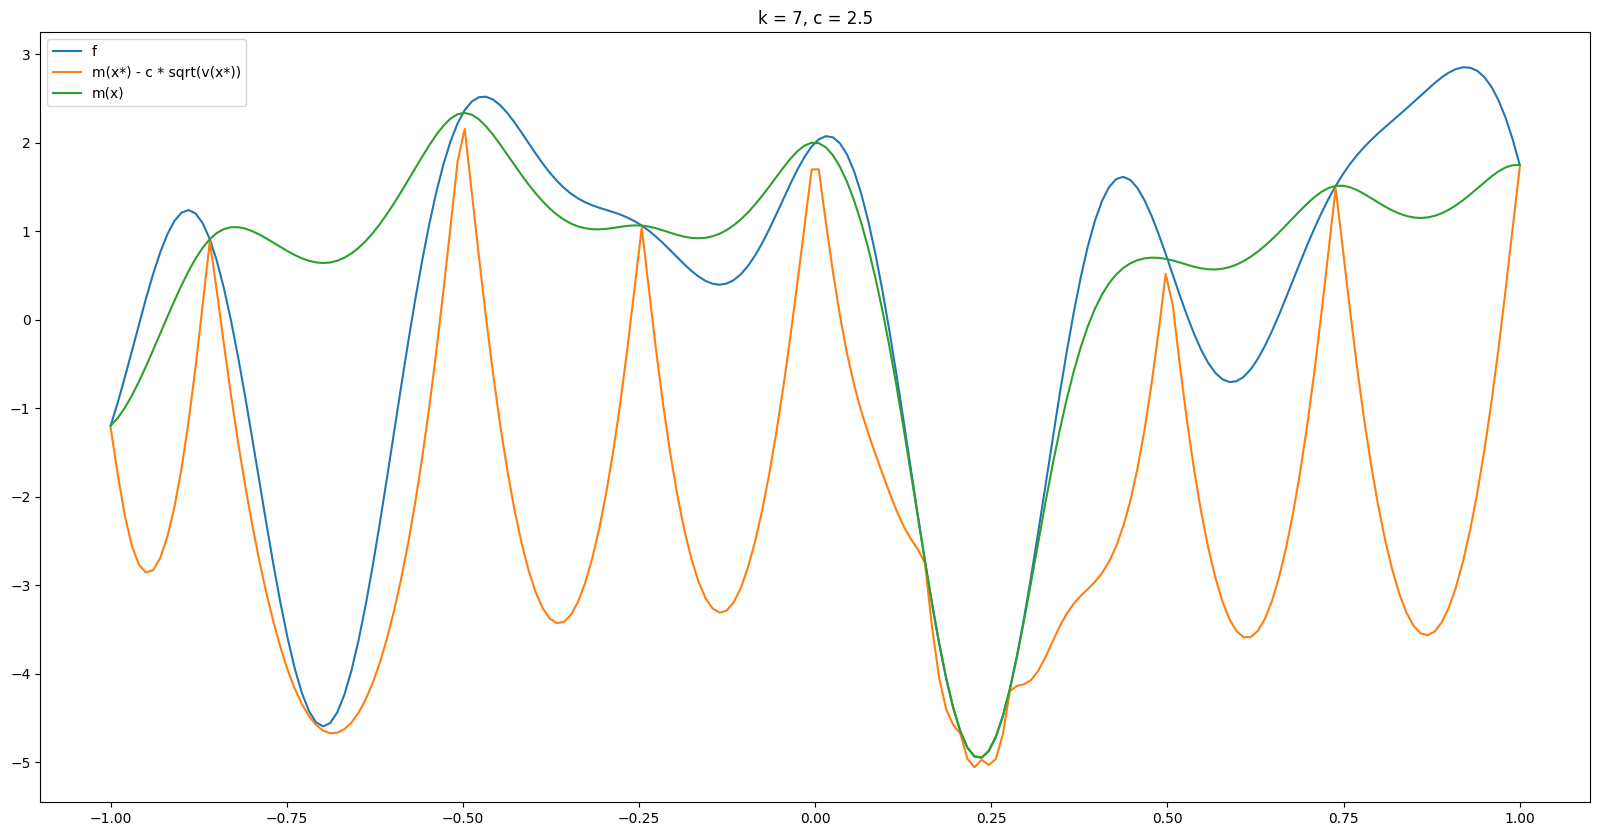

Sample: 100%|██████████| 110/110 [00:03, 30.47it/s, step size=7.01e-02, acc. prob=0.983]


-4.968592 123


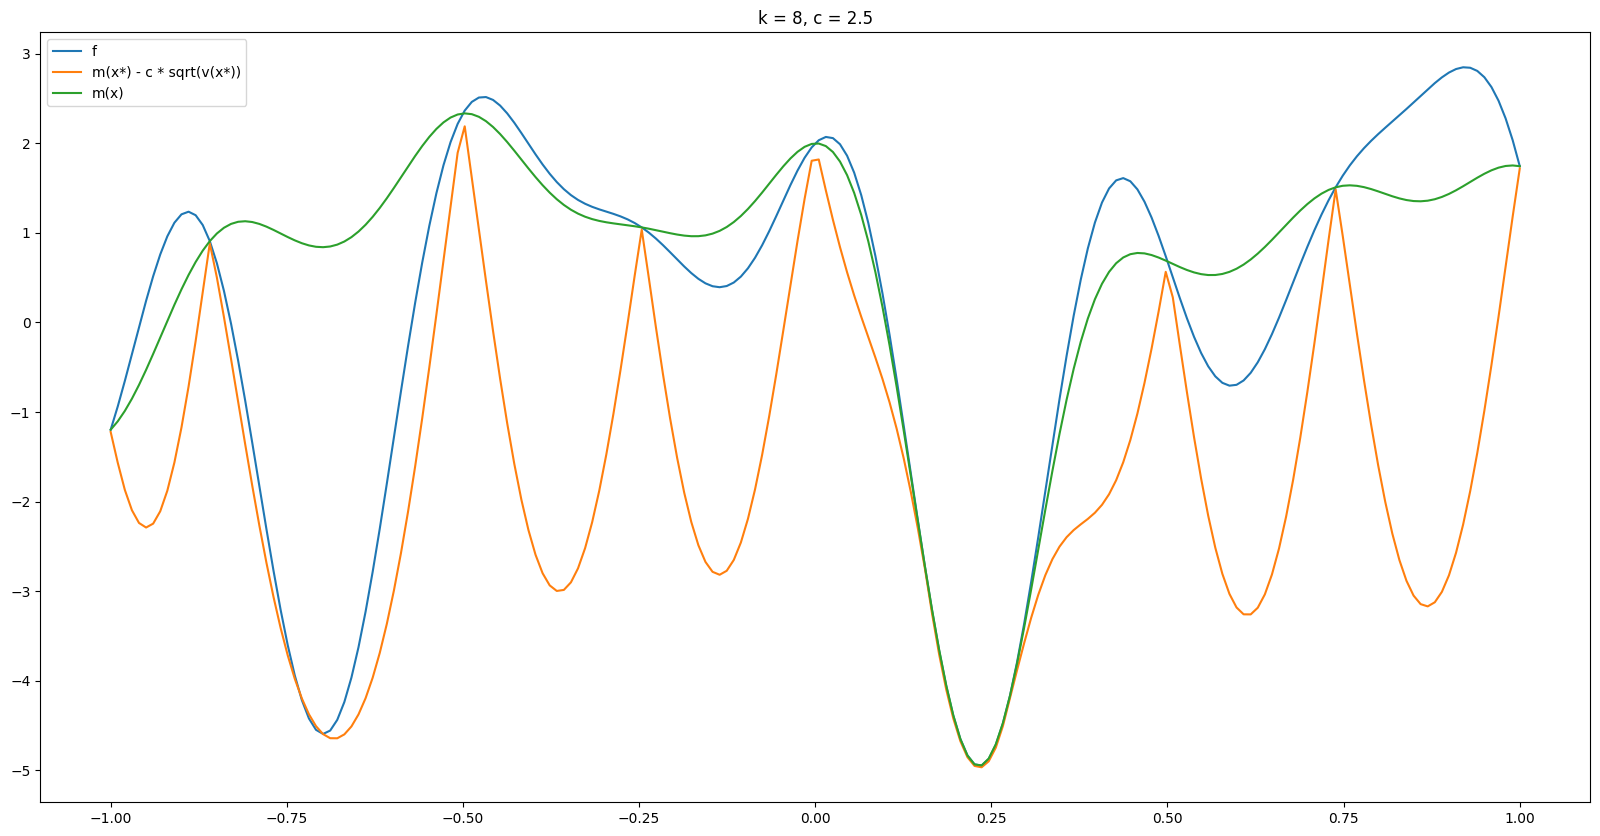

Sample:  77%|███████▋  | 85/110 [03:19,  2.70s/it, step size=9.63e-04, acc. prob=0.956]

KeyboardInterrupt: 

In [57]:
UCB(10, 2.5)